In [ ]:
# In this file, trying lightGBM with cross validation
# try the package in scikit-learn too
# single thread

# lgb document: http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html#lightgbm-package
# xgb document: http://xgboost.readthedocs.io/en/latest/python/python_api.html

# LightGBM scikit-learn API: http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html#scikit-learn-api
# XGBoost scikit-learn API: http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# both scikit-learn lightGBM, Xgboost provide regressor and classifier

In [17]:
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame 
import lightgbm as lgb 
import xgboost as xgb 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split 

In [8]:
data=pd.read_csv('adult.csv',header=None) 
# assign column names to the data
data.columns=['age','workclass','fnlwgt','education','education-num','marital_Status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','Income'] 
data.head()

,age,workclass,fnlwgt,education,education-num,marital_Status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
# data preprocessing

## encode label
l=LabelEncoder() 
l.fit(data.Income) 
l.classes_ 
data.Income=Series(l.transform(data.Income))
data.Income.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

In [10]:
## convert categorical data into one-hot, and drop original categorical data
one_hot_workclass=pd.get_dummies(data.workclass) 
one_hot_education=pd.get_dummies(data.education) 
one_hot_marital_Status=pd.get_dummies(data.marital_Status) 
one_hot_occupation=pd.get_dummies(data.occupation)
one_hot_relationship=pd.get_dummies(data.relationship) 
one_hot_race=pd.get_dummies(data.race) 
one_hot_sex=pd.get_dummies(data.sex) 
one_hot_native_country=pd.get_dummies(data.native_country) 

data.drop(['workclass','education','marital_Status','occupation','relationship','race','sex','native_country'],axis=1,inplace=True) 

In [ ]:
data=pd.concat([data,one_hot_workclass,one_hot_education,one_hot_marital_Status,one_hot_occupation,one_hot_relationship,one_hot_race,one_hot_sex,one_hot_native_country],axis=1) 
## remove dulpicate columns 
i = np.unique(data.columns, return_index=True) 
data=data.iloc[:, i[1]]  # use the index of unique columns
data.head()

In [12]:
features = data.drop('Income',axis=1) 
label = data.Income

In [13]:
label.mode()[0]
label.fillna(label.mode()[0],inplace=True)  # impute missing data with mode

In [14]:
label.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

In [18]:
features_train,features_test,label_train,label_test=train_test_split(features,label,test_size=.3)

In [20]:
# method 1 - xgboost, with cross validation

dtrain=xgb.DMatrix(features_train,label=label_train)
dtest=xgb.DMatrix(features_test)
## booster params
booster_params = {'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [49]:
num_boost_round = 50
nfold = 5
metrics = ('auc', 'logloss')
seed = 410

xgb_cv = xgb.cv(booster_params, dtrain, num_boost_round, nfold, metrics, seed)
print(xgb_cv.shape)

(50, 4)


In [48]:
xgb_cv   # it returns the optimum number of trees required (n_estimators)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.850824,0.003935,0.859200,0.001329
1,0.852598,0.003079,0.861530,0.001734
2,0.853106,0.003554,0.862625,0.001434
3,0.854285,0.004212,0.863689,0.001647
4,0.855042,0.004495,0.864591,0.000981
5,0.855559,0.004038,0.865549,0.000874
6,0.856063,0.003676,0.866360,0.001218
7,0.856301,0.003618,0.866771,0.001364
8,0.856692,0.003609,0.867315,0.001473
9,0.857321,0.003379,0.867708,0.001699


In [85]:
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 
from xgboost import plot_importance
%matplotlib inline

In [86]:
# CV method 1 - xgboost cv() method

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = dtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=('auc'), early_stopping_rounds=early_stopping_rounds, seed = 410)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg_fit = alg.fit(features_train, label_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features_train)
    dtrain_predprob = alg.predict_proba(features_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(label_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(label_train, dtrain_predprob))
                    
    plot_importance(alg_fit, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True,)


Model Report
Accuracy : 0.8522
AUC Score (Train): 0.894681
0:00:20.234687


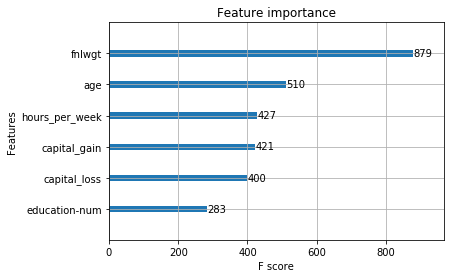

In [87]:
start=datetime.now()

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=410)
modelfit(xgb1, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm) 